<a href="https://colab.research.google.com/github/EngOsamaHaikal/Time-series-forecasting-Task1/blob/master/src/LSTM_Task1_Graduation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time series forcasting**

## **Humidity Predictor model**



### **Import libraries**


In [ ]:
#!pip install statsmodels --upgrade


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
#from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import tensorflow as tf
import numpy as np
import os


### **Import the Data** 

In [ ]:
sensor_data = pd.read_csv('/content/TVC_logger_ 3_betula.csv')


In [ ]:
sensor_data.head()

,Record,DateTime,Tsoil.C.hummock,Tair.C,RH.percent,VWC.m3.per.m3.interhummock,VWC.m3.per.m3.hummock
0,1,2013-08-02 23:40:00,11.0269,15.7624,79.46,0.26180,0.13680
1,2,2013-08-02 23:50:00,10.9539,15.5471,80.05,0.26124,0.13736
2,3,2013-08-03 00:00:00,10.8977,15.0431,80.83,0.26156,0.13704
3,4,2013-08-03 00:10:00,10.8319,14.2438,82.57,0.26229,0.13736
4,5,2013-08-03 00:20:00,10.7582,13.8772,85.02,0.26201,0.13704


### **Analyze the data**

#### **Find correleation between columns**

In [ ]:
sensor_data.corr()


,Record,Tsoil.C.hummock,Tair.C,RH.percent,VWC.m3.per.m3.interhummock,VWC.m3.per.m3.hummock
Record,1.000000,0.013548,0.116478,-0.169807,-0.064155,-0.072711
Tsoil.C.hummock,0.013548,1.000000,0.861115,-0.217757,0.846866,0.893395
Tair.C,0.116478,0.861115,1.000000,-0.330314,0.790640,0.798533
RH.percent,-0.169807,-0.217757,-0.330314,1.000000,-0.165654,-0.081374
VWC.m3.per.m3.interhummock,-0.064155,0.846866,0.790640,-0.165654,1.000000,0.930871
VWC.m3.per.m3.hummock,-0.072711,0.893395,0.798533,-0.081374,0.930871,1.000000


#### **Convert the required column to array**

In [ ]:
humidity_reads = np.array(sensor_data["VWC.m3.per.m3.hummock"])
print(pd.DataFrame(humidity_reads).head())
print("----------------------------------")
print(humidity_reads)

         0
0  0.13680
1  0.13736
2  0.13704
3  0.13736
4  0.13704
----------------------------------
[0.1368  0.13736 0.13704 ... 0.1318  0.1318  0.1318 ]


#### **General statistics** 

In [ ]:
print(sensor_data['VWC.m3.per.m3.hummock'].describe())

count    107823.000000
mean          0.081777
std           0.053661
min           0.015010
25%           0.024300
50%           0.101440
75%           0.133200
max           0.212400
Name: VWC.m3.per.m3.hummock, dtype: float64


In [ ]:
humidity_reads.size
time = np.arange(107823)


In [ ]:
print(time)

[     0      1      2 ... 107820 107821 107822]


#### **Plot** 

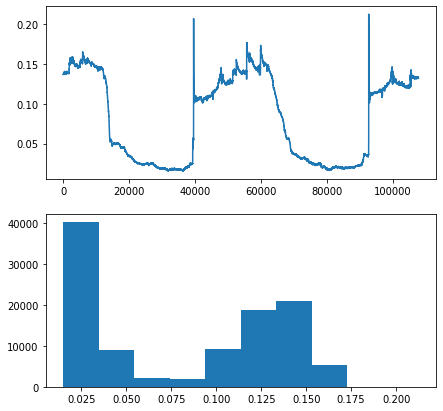

In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)

plt.plot(time , humidity_reads)

# or sensor_data.plot(y='VWC.m3.per.m3.hummock') using pandas functions
plt.subplot(2,1,2)
plt.hist(humidity_reads)
plt.show()

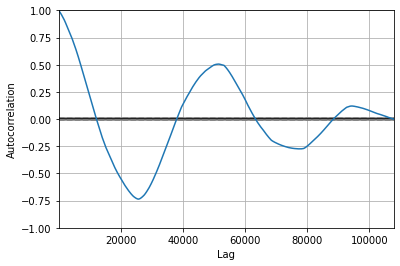

In [ ]:
pd.plotting.autocorrelation_plot(humidity_reads)

### **Build the baseline Model**

#### **Create dataset lagged by 1 time step** 

> Shift the data by one and see the correlaton between the value at each time step with the value at the next time step








In [ ]:


humidity_series = pd.DataFrame(sensor_data['VWC.m3.per.m3.hummock'].values)
humidity_shifted = pd.concat([humidity_series.shift(1), humidity_series], axis=1)
humidity_shifted.columns = ['t-1', 't+1']
print("the Shifted Data by one time step\n")

print(humidity_shifted.head(5))
correleation = humidity_shifted.corr()
print("----------------------------")
print("Correlation\n")
print(correleation)

the Shifted Data by one time step

       t-1      t+1
0      NaN  0.13680
1  0.13680  0.13736
2  0.13736  0.13704
3  0.13704  0.13736
4  0.13736  0.13704
----------------------------
Correlation

          t-1       t+1
t-1  1.000000  0.999964
t+1  0.999964  1.000000


#### **Split into train and vailidation**



> Split the dataset into 70% of training data and 30% for validation data

> The same process for the time (x-axis)







In [ ]:
split_ratio = int(len(time)*0.70)
time_train = time[:split_ratio]
x_train = humidity_reads[:split_ratio]
time_valid = time[split_ratio:]
x_valid = humidity_reads[split_ratio:]

#### **Train the model**



> Use the current output (t) to predict the output at the next time step (t+1).
ASsuming that the next value will be the same

> humidity reads[k,-1]
k is the starting point of the validation data set 
and -1

> **meaning**:

>>copy the values from k until the last value of out data set











In [ ]:
baseline_model = humidity_reads[split_ratio - 1:-1]
print(baseline_model)

[0.025  0.025  0.0243 ... 0.1318 0.1318 0.1318]


#### **Results**

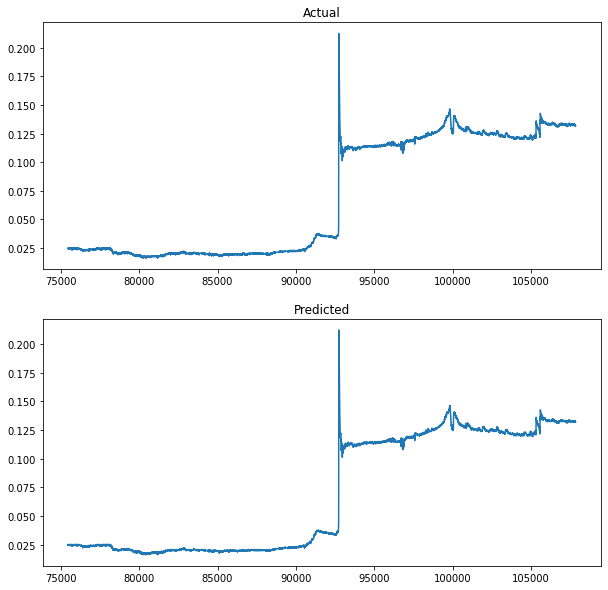

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.title("Actual")
plt.plot(time_valid, x_valid)
plt.subplot(2,1,2)
plt.title("Predicted")

plt.plot(time_valid, baseline_model)

In [ ]:
mse= mean_squared_error(x_valid,baseline_model)
print("mse = {0:.10f}".format(mse))

mse = 0.0000002550


### **Build the CNN forcasting model**

In [ ]:
keras= tf.keras

In [ ]:
def seq2seq_window_dataset(series,
                           window_size,
                           batch_size=32,
                           shuffle_buffer=1000):
  

    series = tf.expand_dims(series, axis=-1)

    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    ds = ds.shuffle(shuffle_buffer)

    ds = ds.map(lambda w: (w[:-1], w[1:]))

    return ds.batch(batch_size).prefetch(1)
  

#### **Prepare data for machine learning model**


> **from_tesnsor_slices function**:

*   Create a dataset where each item corresponds to one time step



> **window method**

*   **window_size** specifies the number of values are taken
*   **Shift =1** means that each window is shifted by one time step to the previews window as below:
 
*   **drop_remainder=True** makes our windows  with same window size 




> 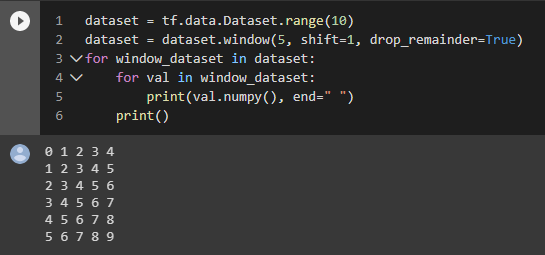

> **Flat_map method**

* convert the windows into tensors of size window

* it groups the elements of each window in order to get tensors and batch method creates batches of window size 

> **map method** 

* convert each window to features and labels with taking the itmes except the last item to be features and the last item be the label

> 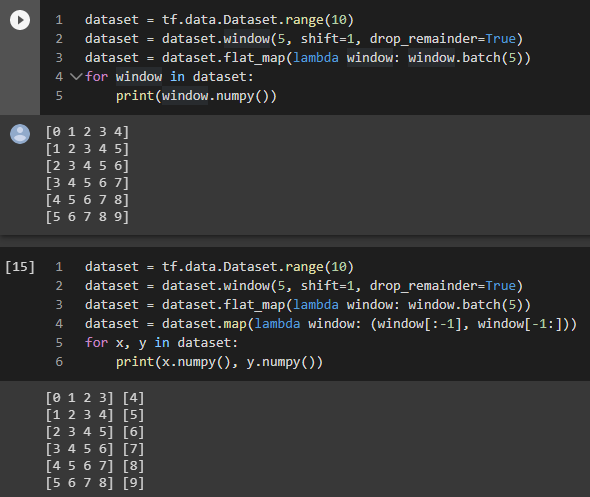

> **In the return method** batch takes multiple windows at a time and the prefetch will load the next batch of data while its working on the current batch.

**batch size**: number of windows are taken
>>  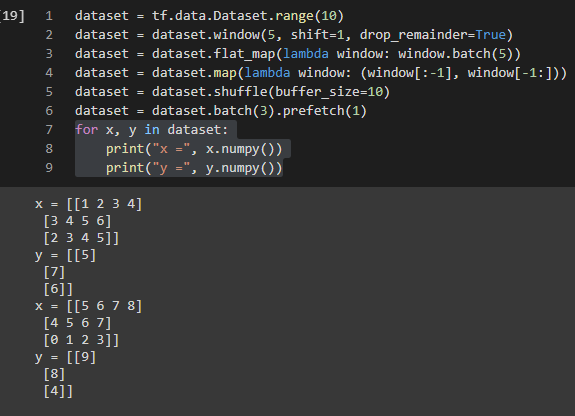



#### **Build and fit the wavenet model**
Forecasting using 1D cnn layers.

* 1D means that it is strides in one dimention which it is the time in our case

* Each output computed based on (n) input time steps where n it is number of filters

* in this formula ReLU(WoXo+W1X1+...+WnXn + bias)

* then create a Sequential model and add out layers

* First layer it is the input layer

* Then add 6 hidden 1D-CNN layers with these hyperparameets:

* padding casual : add zeros just at the left meaning that our model will depend just on the past values
8
* Sttides = 1 , means that the filter shifted by 1 each computation process

* kernal size the size of the filter is two means that there is two output at the same time step in the hidden layers

* Dialaton rate animation and meaning 

https://medium.com/@satyam.kumar.iiitv/understanding-wavenet-architecture-361cc4c2d623

animation :
https://lh3.googleusercontent.com/Zy5xK_i2F8sNH5tFtRa0SjbLp_CU7QwzS2iB5nf2ijIf_OYm-Q5D0SgoW9SmfbDF97tNEF7CmxaL-o6oLC8sGIrJ5HxWNk79dL1r7Rc=w1440-rw-v1


Huber loss :
https://www.machinecurve.com/index.php/2019/10/12/using-huber-loss-in-keras/

keras.callbacks.EarlyStopping:

at the end of each learning loop it will stops the training when the models stops improving and this help in reduce overfitting


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 4
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=164)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=164)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

model.add( keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          padding="causal",
                          activation="relu")
    )
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.add(keras.layers.LSTM(32, return_sequences=True)),
model.add(keras.layers.LSTM(32, return_sequences=True)),
model.add(keras.layers.Dense(1)),

optimizer = keras.optimizers.Adam(lr=2e-5)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint("LSTM_CNN.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=20)

history = model.fit(train_set, epochs=350,
                    
                    validation_data=valid_set,

                    callbacks=[early_stopping,
                               model_checkpoint])

In [ ]:
model = keras.models.load_model("LSTM_CNN.h5")

#### **Test on vailidation dataset**

> This function takes 3 parameters 

*   The model 
*   the time series data
*   the window_size

> first 3 lines same as the window_dataset method above but this time without mapping the data into x,y since we just want to predict not train 





 



In [ ]:


def model_forecast(model, series, window_size):
  
    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(window_size, shift=1, drop_remainder=True)
    
    ds = ds.flat_map(lambda w: w.batch(window_size))

    ds = ds.batch(32).prefetch(1)

    forecast = model.predict(ds)
    
    return forecast

In [ ]:
cnn_forecast = model_forecast(model, humidity_series , window_size)
cnn_forecast = cnn_forecast[split_ratio - window_size:-1, -1, 0]

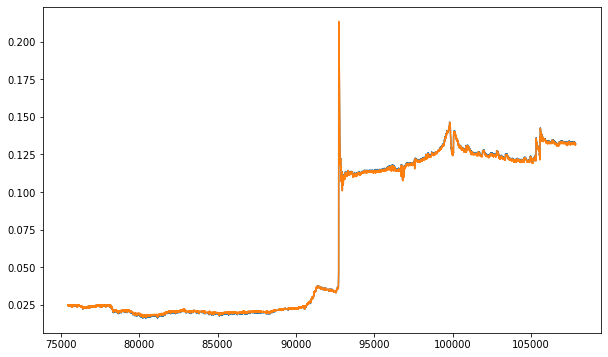

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, cnn_forecast)

#### **Mean absolute error**

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()